<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/edgar/Rakuten_py_NLP_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING TEXT

Import libraries:

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
 
from nltk.tokenize import word_tokenize

Récuperer les données:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('french'))
 
df_X = pd.read_csv('/content/drive/My Drive/Rakuten/X_train_update.csv',index_col=0)
df_y = pd.read_csv('/content/drive/My Drive/Rakuten/Y_train_CVw08PX.csv',index_col=0)
 
#df_X = pd.read_csv(r'C:\Users\Edgar\Documents\Rakuten\X_train_update.csv')
#df_y = pd.read_csv(r'C:\Users\Edgar\Documents\Rakuten\Y_train_CVw08PX.csv')

In [6]:
lemmatizer = WordNetLemmatizer()
 
def lemma(sentence): #Lemmatizer
    doc = word_tokenize(sentence, language='french')
    return [lemmatizer.lemmatize(token) for token in doc]
 
def stop_words_filetring(mots) : 
    tokens = []
    for mot in mots:
        if mot not in stop_words:
            tokens.append(mot)
    return tokens
 
def clean_text(text):
    string = ''
    words = word_tokenize(text.lower(), language='french')
    for word in words:
        if word not in stop_words:
            #if word.isascii(): #and word.isalpha():
            string += lemmatizer.lemmatize(word) + ' '
    return string

In [7]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

On netoye un peu le texte:

In [8]:
X = df_X.designation.astype(str) + ' ' + df_X.description.astype(str)
y = df_y.prdtypecode
 
X_clean = X.apply(lambda cell: clean_text(cell))
X_clean

0        olivia : personalisiertes notizbuch / 150 seit...
1        journal art ( ) n° 133 28/09/2001 - l'art marc...
2        grand stylet ergonomique bleu gamepad nintendo...
3        peluche donald - europe - disneyland 2000 ( ma...
4        guerre tuques luc a id & eacute ; grandeur . v...
                               ...                        
84911                     the sims [ import anglais ] nan 
84912    kit piscine acier nevada déco pierre ø 3.50m x...
84913    journal officiel republique francaise n° 46 15...
84914    table basse bois récupération massif base blan...
84915    gomme collection 2 gommes pinguin glace vert o...
Length: 84916, dtype: object

Combien de mots uniques?

In [9]:
lis = []
for element in X_clean.str.split():
    for word in element:
        lis.append(word)

len(list(set(lis)))

235642

Transformer les categories en numeros de 0 à 26

In [10]:
categories = list(set(y.to_list()))
y_trans = y
i = 0
for category in categories:
    y_trans = y_trans.replace(category,i)
    i+=1

y_trans

0         4
1        25
2        20
3         0
4         6
         ..
84911    17
84912    10
84913    25
84914    11
84915    23
Name: prdtypecode, Length: 84916, dtype: int64

Separer en train et test

In [11]:
# Importer la classe train_test 
from sklearn.model_selection import train_test_split

# Séparer le jeu de données en données d'entraînement et données test 
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_trans.astype(str),train_size = 0.1, test_size=0.02)

Vectoriser avec TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(analyzer='word',
                  tokenizer=word_tokenize,
                      #strip_accents='unicode',
                      #stop_words=french_stop_words_no_accent, # peut etre interessant parce que lisse la progression
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
                  )

X_train_trans = tfid.fit_transform(X_train)
X_test_trans = tfid.transform(X_test)

In [13]:
X_train_trans = X_train_trans.todense()

In [14]:
X_test_trans = X_test_trans.todense()

In [15]:
input_dim = X_train_trans.shape[1]
input_dim

79325

Vectoriser avec Countvectorizer:

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser un objet vectorisateur
vectorizer = CountVectorizer()

# Mettre à jour la valeur de X_train et X_test
cv = vectorizer.fit(X_train)

X_train_trans = cv.transform(X_train).todense()
X_test_trans = cv.transform(X_test).todense()

input_dim = X_train_trans.shape[1]

Deep Learning:

In [17]:
#vectorize the labels
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [18]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=input_dim))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(27, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2962624   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1755      
Total params: 2,968,539
Trainable params: 2,968,539
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(X_train_trans,
                    one_hot_train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test_trans, one_hot_test_labels))

Epoch 1/20
17/17 [==============================] - 7s 374ms/step - loss: 2.9617 - accuracy: 0.3311 - val_loss: 2.2106 - val_accuracy: 0.5592
Epoch 2/20
17/17 [==============================] - 6s 353ms/step - loss: 1.9017 - accuracy: 0.6841 - val_loss: 1.8492 - val_accuracy: 0.6004
Epoch 3/20
17/17 [==============================] - 6s 355ms/step - loss: 1.3966 - accuracy: 0.7690 - val_loss: 1.6103 - val_accuracy: 0.6386
Epoch 4/20
17/17 [==============================] - 6s 355ms/step - loss: 1.0593 - accuracy: 0.8194 - val_loss: 1.4339 - val_accuracy: 0.6639
Epoch 5/20
17/17 [==============================] - 6s 355ms/step - loss: 0.7884 - accuracy: 0.8742 - val_loss: 1.3442 - val_accuracy: 0.6833
Epoch 6/20
17/17 [==============================] - 6s 358ms/step - loss: 0.6025 - accuracy: 0.9129 - val_loss: 1.3009 - val_accuracy: 0.6969
Epoch 7/20
17/17 [==============================] - 6s 353ms/step - loss: 0.4614 - accuracy: 0.9354 - val_loss: 1.2373 - val_accuracy: 0.7181
Epoch 

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's display its loss and accuracy curves:

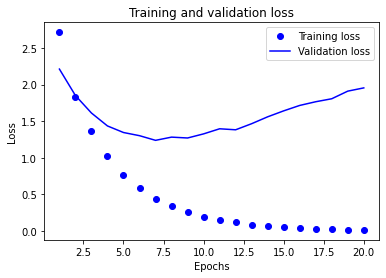

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

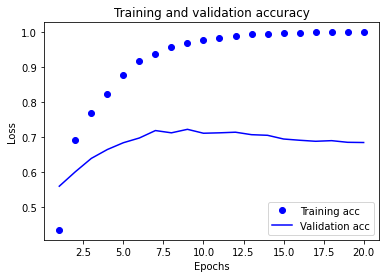

In [23]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#THe model is overfitting
#Il faut changer le modèle afin d'éviter l'overfitting